<a href="https://colab.research.google.com/github/tottenjordan/deep-learning/blob/master/sentiment-stock-analysis/TSLA_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import pandas as pd
import pandas_datareader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas_datareader.data as pdr
from datetime import datetime
import scipy
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller # dickey fuller test

%matplotlib inline

# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
keras.__version__

'2.2.4'

### File Directory

In [0]:
data_dir = "/content/drive/My Drive/Colab Notebooks/stock-tickers"
five_year_stock_returns = "/content/drive/My Drive/Colab Notebooks/stock-tickers/TLSA-Returns-031312-030819.csv"
five_year_stock_features = '/content/drive/My Drive/Colab Notebooks/stock-tickers/vF-TLSA-Features-031312-030819.csv'
five_year_stock_targets = "/content/drive/My Drive/Colab Notebooks/stock-tickers/v2-Full-Target-TLSA-Returns-031312-030819.csv"
subset_no_sentiment_features = "/content/drive/My Drive/Colab Notebooks/stock-tickers/TSLA-No-Sentiment-Features.csv"
subset_sentiment_stock_targets = '/content/drive/My Drive/Colab Notebooks/stock-tickers/TSLA-Sentiment-Target-Signals.csv'
subset_sentiment_stock_features = '/content/drive/My Drive/Colab Notebooks/stock-tickers/v6-TSLA-Returns-Aug18-Mar19.csv'

# Stock Prediction: Closing Price
* predict closing price
* no sentiment analysis

In [0]:
data = pd.read_csv(five_year_stock_returns)
data.head()

,date,open,high,low,close,volume,returns,log_returns
0,2014-03-13,243.79,244.1900,234.00,237.79,6236325,-0.015322,-0.015440
1,2014-03-14,235.29,236.9365,228.32,230.97,8289733,-0.028681,-0.029100
2,2014-03-17,234.95,237.9300,230.50,233.98,5912592,0.013032,0.012948
3,2014-03-18,236.95,241.5000,235.02,240.04,6242349,0.025900,0.025570
4,2014-03-19,241.39,241.5500,233.51,235.84,5071327,-0.017497,-0.017652


In [0]:
fname = os.path.join(data_dir, five_year_stock_returns)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:1256]

print(header)
print(len(lines))

['date', 'open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns']
1255


In [0]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data[i, :] = values

float_data

array([[ 2.43790000e+02,  2.44190000e+02,  2.34000000e+02, ...,
         6.23632500e+06, -1.53215454e-02, -1.54401331e-02],
       [ 2.35290000e+02,  2.36936500e+02,  2.28320000e+02, ...,
         8.28973300e+06, -2.86807687e-02, -2.91000993e-02],
       [ 2.34950000e+02,  2.37930000e+02,  2.30500000e+02, ...,
         5.91259200e+06,  1.30319955e-02,  1.29478097e-02],
       ...,
       [ 2.82000000e+02,  2.84000000e+02,  2.70100000e+02, ...,
         1.87647400e+07, -3.09083263e-02, -3.13960651e-02],
       [ 2.76480000e+02,  2.81505800e+02,  2.74390000e+02, ...,
         1.03354850e+07, -1.08483402e-03, -1.08542288e-03],
       [ 2.78840000e+02,  2.84700000e+02,  2.74250000e+02, ...,
         9.44248300e+06,  1.26701419e-03,  1.26621221e-03]])

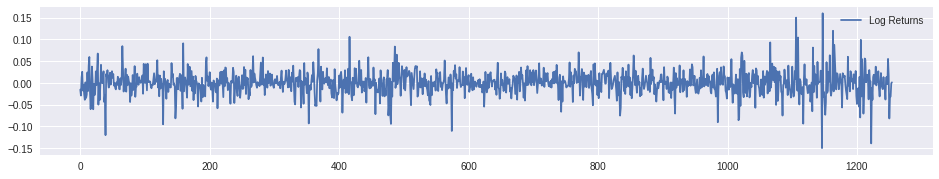

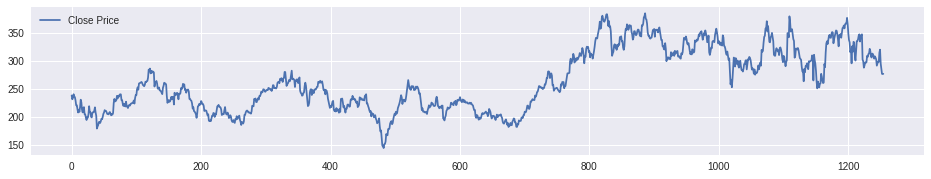

In [0]:
close = float_data[:, 3]  # closing price
log_r = float_data[:, 6]  # log return

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(len(log_r)), log_r, label='Log Returns')
plt.legend(loc='best')
plt.figure(figsize=(16,6))
plt.subplot(212)
plt.plot(range(len(close)), close, label='Close Price')
plt.legend(loc='best')
#plt.tight_layout()

In [0]:
mean = float_data[:750].mean(axis=0)
float_data -= mean
std = float_data[:750].std(axis=0)
float_data /= std

### Data Generator

* This generator yields a tuple `(samples, targets)` 
* `samples` = one batch of input data and `targets` isthe corresponding arrary of target close prices
* **data** is the original array of floating point data (normalized)
* **lookback** = how many timesteps back the input data should go
* **delay** = how many timesteps in the future the target should be
* **min_index** and **max_index** = indices in the data array that delimt which time steps to draw from (useful when using validation data)
* **shuffle** = whether to shuffle the samples or draw them in chronological order
* **bach_size** = the number of samples per batch
* **step** = the period, in timesteps, at which you sample data. 1 timestep = 1 day


In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][3] # closing price
        yield samples, targets

In [0]:
lookback = 15 #
step = 5 #
delay = 1
batch_size = 32

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=750,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=751,
                    max_index=1000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1000 - 751 - lookback) #// batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 1001 - lookback) #// batch_size

print(val_steps)
print(test_steps)
print(len(float_data))

234
239
1255


In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 3] # close price
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.5960224102143753


### Baseline machine learning approach
* fully connected model
* starts by flattening the data 
* two dense layers
* no activation function (typical of regression problem) 
* use MAE as loss 
* results should be comparable to the baseline, no machine learning problem

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 15s 31ms/step - loss: 0.4516 - val_loss: 1.3917
Epoch 2/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3763 - val_loss: 1.5012
Epoch 3/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3644 - val_loss: 1.5587
Epoch 4/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3533 - val_loss: 1.4718
Epoch 5/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3469 - val_loss: 1.8017
Epoch 6/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3424 - val_loss: 1.3738
Epoch 7/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3362 - val_loss: 1.6623
Epoch 8/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3340 - val_loss: 1.9079
Epoch 9/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3294 - val_loss: 1.7073
Epoch 10/10
500/500 [==============================] - 2s 3ms/step - loss: 0.3214 - val_loss: 1.74

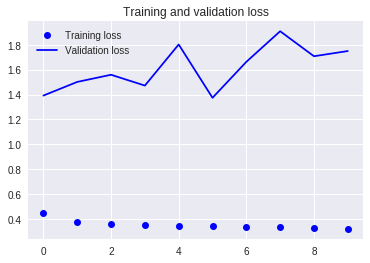

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our common sense contains already a lot of valuable information that a machine learning model does not have access to.

That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

### First RNN baseline
* First machine learning baseline (2D fully connected) did not consider time (sequences). the input data was flattened
* Now use a gated recurrent unit (GRU) layer

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 16s 31ms/step - loss: 0.4264 - val_loss: 2.5218
Epoch 2/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3924 - val_loss: 2.4906
Epoch 3/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3784 - val_loss: 2.8594
Epoch 4/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3736 - val_loss: 2.8963
Epoch 5/10
500/500 [==============================] - 3s 5ms/step - loss: 0.3607 - val_loss: 2.5996
Epoch 6/10
500/500 [==============================] - 3s 5ms/step - loss: 0.3480 - val_loss: 2.8130
Epoch 7/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3353 - val_loss: 2.7981
Epoch 8/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3296 - val_loss: 2.6558
Epoch 9/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3141 - val_loss: 2.6938
Epoch 10/10
500/500 [==============================] - 3s 5ms/step - loss: 0.3111 - val_loss: 2.73

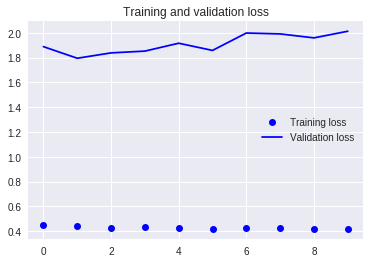

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### RNN with dropout to fight overfitting

In [0]:
model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 14s 28ms/step - loss: 0.4680 - val_loss: 1.7439
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4561 - val_loss: 1.9076
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4566 - val_loss: 1.8998
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4543 - val_loss: 1.8861
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4473 - val_loss: 1.9509
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4494 - val_loss: 1.9719
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4453 - val_loss: 2.1180
Epoch 8/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4503 - val_loss: 2.0257
Epoch 9/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4502 - val_loss: 2.0152
Epoch 10/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4442 - val_loss: 1.96

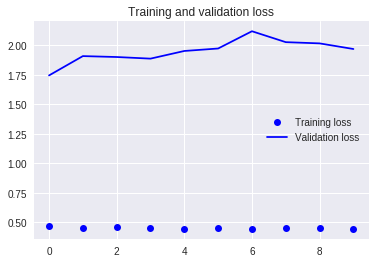

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Stacking GRU Layers with Dropout

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 33ms/step - loss: 0.4677 - val_loss: 1.7941
Epoch 2/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4482 - val_loss: 1.7702
Epoch 3/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4489 - val_loss: 1.8411
Epoch 4/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4478 - val_loss: 1.8824
Epoch 5/20
500/500 [==============================] - 3s 5ms/step - loss: 0.4384 - val_loss: 1.7119
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4384 - val_loss: 1.7301
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4439 - val_loss: 1.9197
Epoch 8/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4344 - val_loss: 1.8763
Epoch 9/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4374 - val_loss: 1.8692
Epoch 10/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4341 - val_loss: 1.88

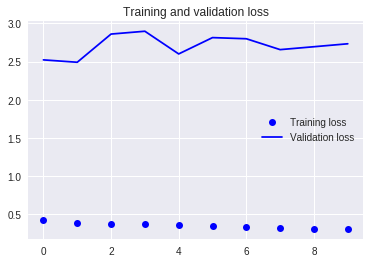

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Stock Prediction: Returns
* in finance, seeking stationary data is optimal. Let's see if the RNN performs better with log_returns
* predict Returns
* no sentiment analysis

In [0]:
data = pd.read_csv(five_year_stock_returns)
data.head()

,date,open,high,low,close,volume,returns,log_returns
0,2014-03-13,243.79,244.1900,234.00,237.79,6236325,-0.015322,-0.015440
1,2014-03-14,235.29,236.9365,228.32,230.97,8289733,-0.028681,-0.029100
2,2014-03-17,234.95,237.9300,230.50,233.98,5912592,0.013032,0.012948
3,2014-03-18,236.95,241.5000,235.02,240.04,6242349,0.025900,0.025570
4,2014-03-19,241.39,241.5500,233.51,235.84,5071327,-0.017497,-0.017652


In [0]:
#data_dir = "/content/drive/My Drive/Colab Notebooks/stock-tickers"
fname = os.path.join(data_dir, five_year_stock_returns)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:1256]

print(header)
print(len(lines))

['date', 'open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns']
1255


In [0]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data[i, :] = values

#float_data

In [0]:
mean = float_data[:750].mean(axis=0)
float_data -= mean
std = float_data[:750].std(axis=0)
float_data /= std

### Data Generator

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=64, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][6] # log returns
        yield samples, targets

In [0]:
lookback = 10
step = 5 #
delay = 1
batch_size = 64

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=750,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=751,
                    max_index=1000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=1001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1000 - 751 - lookback) #// batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 1001 - lookback) #// batch_size

print(val_steps)
print(test_steps)

239
244


In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 6] # log returns
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.989514505879687


### Baseline machine learning approach
* fully connected model
* starts by flattening the data 
* two dense layers
* no activation function (typical of regression problem) 
* use MAE as loss 
* results should be comparable to the baseline, no machine learning problem

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 15s 31ms/step - loss: 0.7037 - val_loss: 0.7340
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 0.6843 - val_loss: 0.7337
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.6740 - val_loss: 0.7381
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.6624 - val_loss: 0.7518
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.6554 - val_loss: 0.7579
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.6486 - val_loss: 0.7582
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 0.6460 - val_loss: 0.7809
Epoch 8/10
500/500 [==============================] - 2s 5ms/step - loss: 0.6349 - val_loss: 0.8769
Epoch 9/10
500/500 [==============================] - 2s 5ms/step - loss: 0.6308 - val_loss: 0.7851
Epoch 10/10
500/500 [==============================] - 2s 5ms/step - loss: 0.6252 - val_loss: 0.78

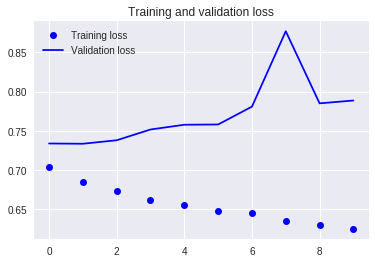

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Stacking GRU Layers with Dropout

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 19s 38ms/step - loss: 0.7093 - val_loss: 0.7027
Epoch 2/10
500/500 [==============================] - 5s 9ms/step - loss: 0.7033 - val_loss: 0.7003
Epoch 3/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6890 - val_loss: 0.7150
Epoch 4/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6788 - val_loss: 0.7095
Epoch 5/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6756 - val_loss: 0.7003
Epoch 6/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6669 - val_loss: 0.7094
Epoch 7/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6536 - val_loss: 0.7256
Epoch 8/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6509 - val_loss: 0.7208
Epoch 9/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6488 - val_loss: 0.7268
Epoch 10/10
500/500 [==============================] - 5s 9ms/step - loss: 0.6269 - val_loss: 0.72

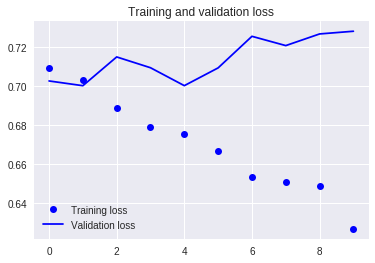

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Increase steps per epoch and decrease epochs

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.7059 - val_loss: 0.7033
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6886 - val_loss: 0.7182
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6720 - val_loss: 0.7356
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6585 - val_loss: 0.7205
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6387 - val_loss: 0.7203
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6228 - val_loss: 0.7389
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6155 - val_loss: 0.7174
Epoch 8/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6007 - val_loss: 0.7145
Epoch 9/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5845 - val_loss: 0.7640
Epoch 10/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5

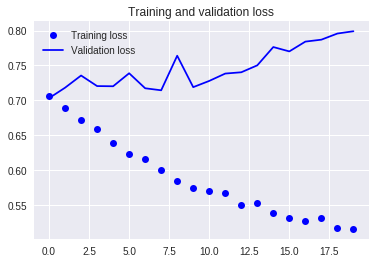

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Predict Positive or Negative Returns

In [0]:
data = pd.read_csv(five_year_stock_returns)
data.head()

,date,open,high,low,close,volume,returns,log_returns
0,2014-03-13,243.79,244.1900,234.00,237.79,6236325,-0.015322,-0.015440
1,2014-03-14,235.29,236.9365,228.32,230.97,8289733,-0.028681,-0.029100
2,2014-03-17,234.95,237.9300,230.50,233.98,5912592,0.013032,0.012948
3,2014-03-18,236.95,241.5000,235.02,240.04,6242349,0.025900,0.025570
4,2014-03-19,241.39,241.5500,233.51,235.84,5071327,-0.017497,-0.017652


In [0]:
#data['returns_signal'] = np.where(data['log_returns'] > 0,1,0)
#data2 = data[['date','returns_signal']]
#data2.to_csv("/content/drive/My Drive/Colab Notebooks/stock-tickers/v2-Full-Target-TLSA-Returns-031312-030819.csv",index=False)
#data3 = data[['date','open','high','low','close','volume','returns','log_returns']]
#data3.to_csv("/content/drive/My Drive/Colab Notebooks/stock-tickers/v2-Full-Features-TLSA-Returns-031312-030819.csv",index=False)
data_targets = pd.read_csv(five_year_stock_targets)
data_targets.head()

,date,returns_signal
0,2014-03-13,0
1,2014-03-14,0
2,2014-03-17,1
3,2014-03-18,1
4,2014-03-19,0


In [0]:
fname = os.path.join(data_dir, five_year_stock_returns)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:1256]

print(header)
print(len(lines))

['date', 'open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns']
1255


In [0]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data[i, :] = values

float_data

array([[ 2.43790000e+02,  2.44190000e+02,  2.34000000e+02, ...,
         6.23632500e+06, -1.53215454e-02, -1.54401331e-02],
       [ 2.35290000e+02,  2.36936500e+02,  2.28320000e+02, ...,
         8.28973300e+06, -2.86807687e-02, -2.91000993e-02],
       [ 2.34950000e+02,  2.37930000e+02,  2.30500000e+02, ...,
         5.91259200e+06,  1.30319955e-02,  1.29478097e-02],
       ...,
       [ 2.82000000e+02,  2.84000000e+02,  2.70100000e+02, ...,
         1.87647400e+07, -3.09083263e-02, -3.13960651e-02],
       [ 2.76480000e+02,  2.81505800e+02,  2.74390000e+02, ...,
         1.03354850e+07, -1.08483402e-03, -1.08542288e-03],
       [ 2.78840000e+02,  2.84700000e+02,  2.74250000e+02, ...,
         9.44248300e+06,  1.26701419e-03,  1.26621221e-03]])

In [0]:
mean = float_data[:750].mean(axis=0)
float_data -= mean
std = float_data[:750].std(axis=0)
float_data /= std
float_data

array([[ 0.77038729,  0.64744245,  0.53021169, ...,  0.47275501,
        -0.62799663, -0.61797795],
       [ 0.43141789,  0.35672333,  0.30374305, ...,  1.25446736,
        -1.16271837, -1.16278238],
       [ 0.41785912,  0.39654265,  0.39066235, ...,  0.34951302,
         0.50689379,  0.51422667],
       ...,
       [ 2.29415444,  2.24302088,  1.96956347, ...,  5.24220014,
        -1.2518795 , -1.25435306],
       [ 2.07402373,  2.14305374,  2.14061109, ...,  2.03326515,
        -0.0581522 , -0.04546485],
       [ 2.16813758,  2.27107676,  2.13502912, ...,  1.69330802,
         0.03598383,  0.0483261 ]])

In [0]:
fname = os.path.join(data_dir, five_year_stock_targets)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:1256]

print(header)
print(len(lines))

float_data2 = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data2[i, :] = values

float_data2

['date', 'returns_signal']
1255


array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [0]:
def generator(data1,data2, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=25, step=1):
    if max_index is None:
        max_index = len(data1) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data1.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data1[indices]
            targets[j] = data2[rows[j] + delay][0] # signal
        yield samples, targets

In [0]:
lookback = 10 
step = 5 #
delay = 1
batch_size = 64

train_gen = generator(data1=float_data,
                      data2=float_data2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=750,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data1=float_data,
                    data2=float_data2,
                    lookback=lookback,
                    delay=delay,
                    min_index=751,
                    max_index=1000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data1=float_data,
                     data2=float_data2,
                     lookback=lookback,
                     delay=delay,
                     min_index=1001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (1000 - 751 - lookback) #// batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 1001 - lookback) #// batch_size

print(val_steps)
print(test_steps)
print(len(float_data))

239
244
1255


## Model 1  
* Minimal drop out
* tanh -> relu -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6731 - acc: 0.5711 - val_loss: 0.7328 - val_acc: 0.5262
Epoch 2/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6377 - acc: 0.6179 - val_loss: 0.7059 - val_acc: 0.5367
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6012 - acc: 0.6559 - val_loss: 0.7437 - val_acc: 0.5262
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5635 - acc: 0.6871 - val_loss: 0.7646 - val_acc: 0.5365
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5402 - acc: 0.7039 - val_loss: 0.7791 - val_acc: 0.5104
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5131 - acc: 0.7270 - val_loss: 0.7614 - val_acc: 0.5417
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4925 - acc: 0.7413 - val_loss: 0.8197 - val_acc: 0.5158
Epoch 8/10
1000/1000 [==============================] - 9s 9

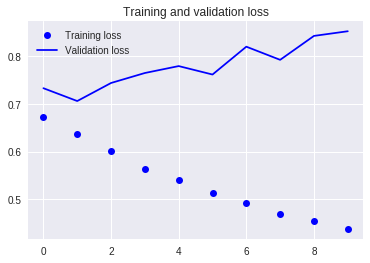

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 2 
* increased dropout
* tanh ->  relu -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.3, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6802 - acc: 0.5558 - val_loss: 0.7074 - val_acc: 0.5311
Epoch 2/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6558 - acc: 0.5935 - val_loss: 0.7138 - val_acc: 0.5262
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6374 - acc: 0.6172 - val_loss: 0.7142 - val_acc: 0.5363
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6173 - acc: 0.6405 - val_loss: 0.7127 - val_acc: 0.5365
Epoch 5/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6045 - acc: 0.6510 - val_loss: 0.7116 - val_acc: 0.5572
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5884 - acc: 0.6665 - val_loss: 0.7284 - val_acc: 0.5258
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5741 - acc: 0.6795 - val_loss: 0.7394 - val_acc: 0.5417
Epoch 8/10
1000/1000 [==============================] - 9s 9

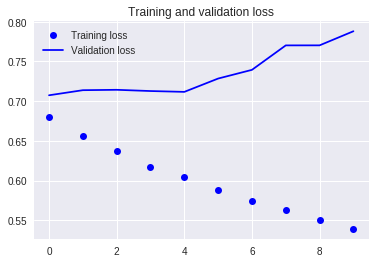

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 3
* increase dropout and steps per epoch
* sigmoid - > sigmoid -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     activation='sigmoid',
                     dropout=0.3,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='sigmoid',
                     dropout=0.3, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1200,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1200/1200 [==============================] - 26s 22ms/step - loss: 0.6921 - acc: 0.5249 - val_loss: 0.7010 - val_acc: 0.4739
Epoch 2/10
1200/1200 [==============================] - 11s 9ms/step - loss: 0.6886 - acc: 0.5420 - val_loss: 0.6951 - val_acc: 0.4897
Epoch 3/10
1200/1200 [==============================] - 10s 9ms/step - loss: 0.6860 - acc: 0.5505 - val_loss: 0.6968 - val_acc: 0.4948
Epoch 4/10
1200/1200 [==============================] - 11s 9ms/step - loss: 0.6815 - acc: 0.5571 - val_loss: 0.6937 - val_acc: 0.5154
Epoch 5/10
1200/1200 [==============================] - 10s 9ms/step - loss: 0.6755 - acc: 0.5695 - val_loss: 0.6940 - val_acc: 0.5156
Epoch 6/10
1200/1200 [==============================] - 10s 9ms/step - loss: 0.6724 - acc: 0.5710 - val_loss: 0.6919 - val_acc: 0.5575
Epoch 7/10
1200/1200 [==============================] - 10s 9ms/step - loss: 0.6697 - acc: 0.5773 - val_loss: 0.6911 - val_acc: 0.5312
Epoch 8/10
1200/1200 [==============================] 

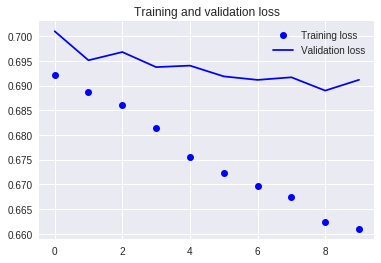

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing Sentiment Analysis

Use stock data from subset range of available sentiment data


### Data Prep

In [0]:
#data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/stock-tickers/TSLA-No-Sentiment-Features.csv")
#data['returns_signal'] = np.where(data['log_returns'] > 0,1,0)
#data.head()

,Date,Open,High,Low,Close,Volume,Returns,log_returns,returns_signal
0,8/21/2018,310.61,324.790,309.00,321.90,13172230,0.043639,0.042714,1
1,8/22/2018,320.87,323.880,314.67,321.64,5945955,-0.000808,-0.000808,0
2,8/23/2018,319.14,327.320,318.10,320.10,5147286,-0.004788,-0.004799,0
3,8/24/2018,320.70,323.850,319.40,322.82,3602564,0.008497,0.008461,1
4,8/27/2018,318.00,322.435,308.81,319.27,13079288,-0.010997,-0.011058,0


In [0]:
#data9 = data[['Date','returns_signal']]
#data9.head()
#data9.to_csv("/content/drive/My Drive/Colab Notebooks/stock-tickers/TSLA-Sentiment-Target-Signals.csv",index=False)

In [0]:
fname = os.path.join(data_dir, subset_no_sentiment_features)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:140]

print(header)
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'log_returns']
139


In [0]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data[i, :] = values

#float_data

mean = float_data[:80].mean(axis=0)
float_data -= mean
std = float_data[:80].std(axis=0)
float_data /= std
#float_data

In [0]:
fname = os.path.join(data_dir, subset_sentiment_stock_targets)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:140]

print(header)
print(len(lines))

float_data2 = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data2[i, :] = values

#float_data2

['Date', 'returns_signal']
139


In [0]:
def generator(data1,data2, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=25, step=1):
    if max_index is None:
        max_index = len(data1) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data1.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data1[indices]
            targets[j] = data2[rows[j] + delay][0] # signal
        yield samples, targets

### Generator

In [0]:
lookback = 6 # 
step = 3 #
delay = 1
batch_size = 12

train_gen = generator(data1=float_data,
                      data2=float_data2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=80,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data1=float_data,
                    data2=float_data2,
                    lookback=lookback,
                    delay=delay,
                    min_index=81,
                    max_index=114,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data1=float_data,
                     data2=float_data2,
                     lookback=lookback,
                     delay=delay,
                     min_index=115,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (114 - 81 - lookback) #// batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 115 - lookback) #// batch_size

print(val_steps)
print(test_steps)
print(len(float_data))

27
18
139


### Model 1: Baseline (without sentiment analysis)

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.2, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.6022 - acc: 0.6622 - val_loss: 1.0301 - val_acc: 0.5031
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4850 - acc: 0.7491 - val_loss: 1.4430 - val_acc: 0.4599
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4065 - acc: 0.7962 - val_loss: 1.6806 - val_acc: 0.4167
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3386 - acc: 0.8413 - val_loss: 2.2404 - val_acc: 0.4167
Epoch 5/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2903 - acc: 0.8737 - val_loss: 2.3622 - val_acc: 0.3765
Epoch 6/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2450 - acc: 0.8953 - val_loss: 2.7439 - val_acc: 0.4167
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.2172 - acc: 0.9099 - val_loss: 2.8502 - val_acc: 0.3765
Epoch 8/10
1000/1000 [==============================] - 7s 7

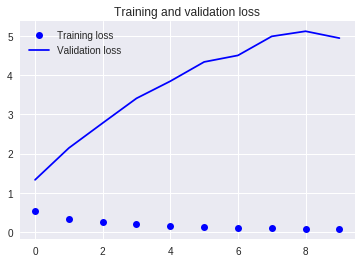

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 2 (without sentiment analysis)

* Increase dropout 
* tanh -> sigmoid -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     activation='tanh',
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='sigmoid',
                     dropout=0.3, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1200/1200 [==============================] - 28s 23ms/step - loss: 0.6251 - acc: 0.6259 - val_loss: 0.9582 - val_acc: 0.4074
Epoch 2/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.4976 - acc: 0.7391 - val_loss: 1.2976 - val_acc: 0.4815
Epoch 3/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.4303 - acc: 0.7824 - val_loss: 1.4714 - val_acc: 0.4074
Epoch 4/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.3803 - acc: 0.8162 - val_loss: 1.6280 - val_acc: 0.4074
Epoch 5/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.3478 - acc: 0.8348 - val_loss: 1.9281 - val_acc: 0.4444
Epoch 6/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.3153 - acc: 0.8551 - val_loss: 2.0248 - val_acc: 0.4444
Epoch 7/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.2931 - acc: 0.8682 - val_loss: 2.1218 - val_acc: 0.4444
Epoch 8/10
1200/1200 [==============================] - 9s 7

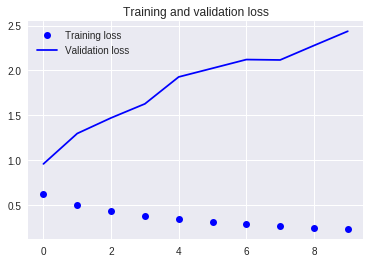

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 3 (without sentiment analysis)
* increase dropout and steps per epoch
* sigmoid - > sigmoid -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     activation='sigmoid',
                     dropout=0.25,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='sigmoid',
                     dropout=0.25, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.6909 - acc: 0.5248 - val_loss: 0.7315 - val_acc: 0.3765
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6606 - acc: 0.5779 - val_loss: 0.7222 - val_acc: 0.4599
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6200 - acc: 0.6352 - val_loss: 0.8330 - val_acc: 0.4167
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5803 - acc: 0.6768 - val_loss: 1.0025 - val_acc: 0.3735
Epoch 5/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5444 - acc: 0.7017 - val_loss: 1.1724 - val_acc: 0.4568
Epoch 6/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5104 - acc: 0.7277 - val_loss: 1.2425 - val_acc: 0.4167
Epoch 7/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4850 - acc: 0.7484 - val_loss: 1.3843 - val_acc: 0.4167
Epoch 8/10
1000/1000 [==============================] - 7s 7

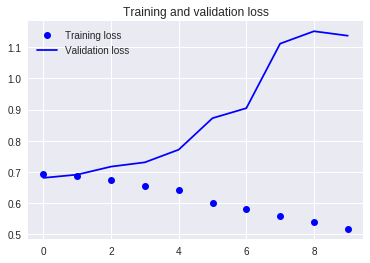

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Add Sentiment Analysis

### Data Prep

In [0]:
fname = os.path.join(data_dir, subset_sentiment_stock_features)

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:140]

print(header)
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'log_returns', 'Sentiment']
139


In [0]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    if len(line) > 0:
      values = [float(x) for x in line.split(',')[1:]]
      float_data[i, :] = values

#float_data

In [0]:
mean = float_data[:80].mean(axis=0)
float_data -= mean
std = float_data[:80].std(axis=0)
float_data /= std
#float_data

In [0]:
def generator(data1,data2, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=25, step=1):
    if max_index is None:
        max_index = len(data1) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data1.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data1[indices]
            targets[j] = data2[rows[j] + delay][0] # signal
        yield samples, targets

In [0]:
lookback = 6 # 
step = 3 #
delay = 1
batch_size = 12

train_gen = generator(data1=float_data,
                      data2=float_data2,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=80,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data1=float_data,
                    data2=float_data2,
                    lookback=lookback,
                    delay=delay,
                    min_index=81,
                    max_index=114,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data1=float_data,
                     data2=float_data2,
                     lookback=lookback,
                     delay=delay,
                     min_index=115,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (114 - 81 - lookback) #// batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 115 - lookback) #// batch_size

print(val_steps)
print(test_steps)
print(len(float_data))

27
18
139


### Model 1: Baseline (with sentiment analysis)

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.2, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1600,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1600/1600 [==============================] - 34s 21ms/step - loss: 0.4842 - acc: 0.7503 - val_loss: 1.0371 - val_acc: 0.5401
Epoch 2/10
1600/1600 [==============================] - 11s 7ms/step - loss: 0.2898 - acc: 0.8757 - val_loss: 1.4464 - val_acc: 0.5833
Epoch 3/10
1600/1600 [==============================] - 12s 7ms/step - loss: 0.2226 - acc: 0.9081 - val_loss: 1.6887 - val_acc: 0.6265
Epoch 4/10
1600/1600 [==============================] - 12s 7ms/step - loss: 0.1873 - acc: 0.9219 - val_loss: 1.9573 - val_acc: 0.5401
Epoch 5/10
1600/1600 [==============================] - 12s 7ms/step - loss: 0.1603 - acc: 0.9336 - val_loss: 2.1658 - val_acc: 0.5432
Epoch 6/10
1600/1600 [==============================] - 12s 7ms/step - loss: 0.1397 - acc: 0.9434 - val_loss: 2.5299 - val_acc: 0.4969
Epoch 7/10
1600/1600 [==============================] - 11s 7ms/step - loss: 0.1218 - acc: 0.9522 - val_loss: 2.6541 - val_acc: 0.4599
Epoch 8/10
1600/1600 [==============================] 

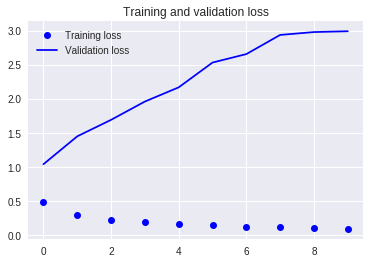

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 2 (with sentiment analysis)

* Increase dropout 
* tanh -> relu -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     activation='tanh',
                     dropout=0.3,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.3, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 27s 55ms/step - loss: 0.6668 - acc: 0.5927 - val_loss: 0.7668 - val_acc: 0.4568
Epoch 2/10
500/500 [==============================] - 4s 8ms/step - loss: 0.5487 - acc: 0.7115 - val_loss: 1.0049 - val_acc: 0.5833
Epoch 3/10
500/500 [==============================] - 4s 8ms/step - loss: 0.4647 - acc: 0.7638 - val_loss: 1.1654 - val_acc: 0.4599
Epoch 4/10
500/500 [==============================] - 4s 8ms/step - loss: 0.4069 - acc: 0.8077 - val_loss: 1.3106 - val_acc: 0.5432
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3834 - acc: 0.8208 - val_loss: 1.4215 - val_acc: 0.5401
Epoch 6/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3502 - acc: 0.8375 - val_loss: 1.5207 - val_acc: 0.4969
Epoch 7/10
500/500 [==============================] - 4s 8ms/step - loss: 0.3362 - acc: 0.8503 - val_loss: 1.5520 - val_acc: 0.5432
Epoch 8/10
500/500 [==============================] - 4s 7ms/step - loss: 

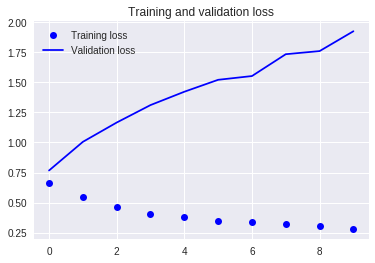

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model 3 (with sentiment analysis)
* increase dropout and steps per epoch
* sigmoid - > sigmoid -> sigmoid

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     activation='sigmoid',
                     dropout=0.35,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='sigmoid',
                     dropout=0.35, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.6912 - acc: 0.5199 - val_loss: 0.6913 - val_acc: 0.5031
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6640 - acc: 0.5837 - val_loss: 0.7566 - val_acc: 0.5370
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6326 - acc: 0.6248 - val_loss: 0.7664 - val_acc: 0.5432
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5967 - acc: 0.6649 - val_loss: 0.8321 - val_acc: 0.5000
Epoch 5/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5656 - acc: 0.6932 - val_loss: 0.8570 - val_acc: 0.4969
Epoch 6/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5397 - acc: 0.7167 - val_loss: 0.9505 - val_acc: 0.5432
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4893 - acc: 0.7553 - val_loss: 1.0266 - val_acc: 0.4969
Epoch 8/10
1000/1000 [==============================] - 7s 7

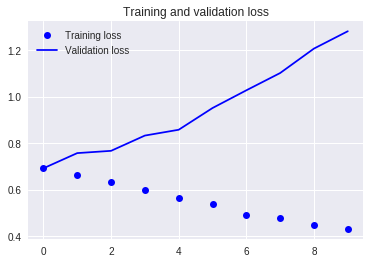

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model 4: Optimizing the Chosen Model

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     activation='tanh',
                     dropout=0.35,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='sigmoid',
                     dropout=0.35, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 37s 37ms/step - loss: 0.6496 - acc: 0.6032 - val_loss: 0.7432 - val_acc: 0.4599
Epoch 2/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5067 - acc: 0.7437 - val_loss: 0.9356 - val_acc: 0.5401
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4170 - acc: 0.7977 - val_loss: 1.1392 - val_acc: 0.5031
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3771 - acc: 0.8234 - val_loss: 1.1796 - val_acc: 0.5802
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3420 - acc: 0.8475 - val_loss: 1.3309 - val_acc: 0.6667
Epoch 6/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3130 - acc: 0.8589 - val_loss: 1.4200 - val_acc: 0.5833
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2932 - acc: 0.8696 - val_loss: 1.4680 - val_acc: 0.5833
Epoch 8/10
1000/1000 [==============================] - 9s 9

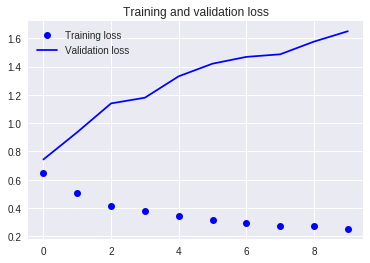

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     activation='tanh',
                     dropout=0.35,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='sigmoid',
                     dropout=0.35, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=10,
                              validation_data=test_gen,
                              validation_steps=test_steps)

Epoch 1/10
1000/1000 [==============================] - 37s 37ms/step - loss: 0.6503 - acc: 0.6082 - val_loss: 0.7310 - val_acc: 0.4167
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5101 - acc: 0.7490 - val_loss: 0.8075 - val_acc: 0.5833
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4244 - acc: 0.8001 - val_loss: 0.9055 - val_acc: 0.5833
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3788 - acc: 0.8254 - val_loss: 0.9635 - val_acc: 0.5000
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3418 - acc: 0.8448 - val_loss: 0.9895 - val_acc: 0.5833
Epoch 6/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3164 - acc: 0.8594 - val_loss: 0.9944 - val_acc: 0.4167
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2995 - acc: 0.8667 - val_loss: 1.1143 - val_acc: 0.5000
Epoch 8/10
1000/1000 [==============================] - 8s 8